# COGS 118A - Final Project

# Flight Price Predictor

## Group members

- Drake Coy
- Aditi Krishnakumar
- Simran Nayyer
- Jasmine Qiang
- Luke Sztajnkrycer

# Abstract 
Our project is centered around accurately predicting the price of flights to find the best booking times and routes. Our goal is to enable customers to plan their trips as efficiently and cost effectively as possible. We examine data collected from ‘Easemytrip,’ an online booking platform, between February 11th and March 31st of 2022 that includes flight information from India about airline companies, flight codes, source/destination cities, flight times, and more. There are 12 total features that mostly take the form of discrete categorical variables (‘Delhi,’ ‘morning,’ ‘economy,’ etc.), and include 300,000 unique observations. We implement linear regression, nonlinear regression, decision tree, and random forest models to make our predictions. Each method is compared using R-squared, adjusted R-squared, root mean squared error, and mean absolute error metrics to evaluate their performance. We will then evaluate our decision tree success rate by using an accuracy classification score based upon the predicted prices, or bucket of prices. We ultimately found that a random forest provided the best results, followed closely by a single decision tree, and then a linear regression model.

# Background

Groves & Gini used a standard PLS regression to construct their model, as well as lagged feature computation to weight temporal relationships in the data. <a name="groves"></a>[<sup>[1]</sup>](#grovesnote)

Wohlfarth et al. used a marked point process of returns to create a piecewise reconstruction of the price trajectory, which they then used to create an intensity image to perform clustering, feature-based classification, and model generation. <a name="Wohlfarth"></a>[<sup>[2]</sup>](#Wohlfarthnote)

Guo & Luh used a committee machine of neural networks, combining RBF and MLP networks to balance local data characteristics with global trends. <a name="Guo"></a>[<sup>[3]</sup>](#Guonote)

Etzioni et al. compared reinforcement learning and rule learning, where the system determined whether to buy or wait for each instance of a ticket price. They also compared those with a moving average model to predict the price of a flight based on its own history. <a name="Etzioni"></a>[<sup>[4]</sup>](#Etzioninote)

In general, most of the prior work seems to agree that for this task, it is important to choose a model that considers more general, long-term patterns as opposed to finer details.

# Problem Statement

When booking flights, there is often a tradeoff between aspects such as comfort (in terms of the airline) and or time spent (duration of the flight) that make the experience uncomfortable in the name of saving money. Our team intends to give insight into what factors influence flight pricing the most so that when readers of our work are booking flights in the future, they will be able to prioritize these factors in order to minimize their flight price. We plan to provide this service through linear regression by establishing relationships between flight price and other factors and through a decision tree by combining various results of our regression to categorize flights.

# Data
Dataset: https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction

Our dataset contains flight data to six metropolitan cities in India from Easemytrip which is an online platform for booking plane tickets. There are 300,261 observations in this dataset and 11 variables per observation. The 11 features are as follows: airline, flight (number), source city, departure time, stops, arrival time, destination city, class, duration, days left (from the booking date till fight date), and price. Some critical variables from this list include the airline, days left, destination city, and stops as we think that these variables logically should have the most influence on the price variable. The dataset seems to be cleaned already but depending on how we aim to explore the analysis, we may need to one-hot encode certain categorical variables.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
#import datasets as Pandas dataframes
#NOTE: the filepath may be different for each user
main_dataset = pd.read_csv('Datasets/Clean_Dataset.csv')
business_df = pd.read_csv('Datasets/business.csv')
economy_df = pd.read_csv('Datasets/economy.csv')

def strtonum(ele):
    if ele == 'zero':
        num = 0
            
    elif ele == 'one':
        num = 1
            
    else:
        num = 2
            
    return num

main_dataset['stops'] = main_dataset['stops'].apply(strtonum)

main_dataset = main_dataset.drop(columns = ['Unnamed: 0'])
main_dataset.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,0,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,0,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,0,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,0,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,0,Morning,Mumbai,Economy,2.33,1,5955


We further transform our data by encoding each of the categorical data strings as numbers for their respective variable, so that regression and other types of modeling can be done more easily. These are converted using LabelEncoder.

For example, airline: 'SpiceJet' becomes airline 4. City 'Delhi' becomes city 2.

In [3]:
encoder = LabelEncoder()
data = main_dataset.drop(['flight'],axis=1)
data['airline'] = encoder.fit_transform(data['airline'])
data['source_city'] = encoder.fit_transform(data['source_city'])
data['departure_time'] = encoder.fit_transform(data['departure_time'])
data['arrival_time'] = encoder.fit_transform(data['arrival_time'])
data['destination_city'] = encoder.fit_transform(data['destination_city'])
data['class'] = encoder.fit_transform(data['class'])

data.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,4,2,2,0,5,5,1,2.17,1,5953
1,4,2,1,0,4,5,1,2.33,1,5953
2,0,2,1,0,1,5,1,2.17,1,5956
3,5,2,4,0,0,5,1,2.25,1,5955
4,5,2,4,0,4,5,1,2.33,1,5955


In [4]:
data['airline'].unique()

array([4, 0, 5, 2, 3, 1])

# Proposed Solution

There is no true way to determine the best tradeoff between comfort, price, and time when it comes to flights. This is primarily due to the fact that individuals have different preferences, available time, amounts of money, etc. Thus, we opt for a solution that takes into account all of these variables, and more, to arrange groups of flights/tickets that have a broad appeal to different consumer groups. For example, we may group a set of flights that share characteristics of low price, medium-to-long flight time, and free luggage booking to cater to individuals who like to travel often and cheaply. We may group another set of flights based on quality of service and amount of reroutes to cater to individuals with greater amounts of money who prefer nice, one-and-done flights.

Notably, while we have some broad ideas of consumer/ticket groups in mind (such as the examples described above), we aim to construct these groups analytically, with variable contents and cutoff (e.g. tickets underneath x price, trip has less than x connecting flights) determined by their relationship to other variables in this dataset. As of now, the best way we believe we can approach this is through Linear Regression. Not only can we use regression to find relationships between our variables, but we can use these relationships to construct ideal ticket categories that appeal to a broad range of people. The fit of the relationship between any two variables can be described by the R-squared metric.

Once we have constructed these ticket categories, we will program a decision tree that classifies each flight by their assigned categories. This should give us a better idea of how each flight grouping is oriented in space (though we may have to resort to dimensionality-reducing methods such as PCA or scrap this visualization if the groups are too hyper-dimensional), and provide us with a simple-yet-effective set of criteria that allow us to arrive at any given group. In the real world, this might translate to a customer being offered a range of tickets that suit their preferences after answering a short list of questions. The shorter the list and the better the accuracy of each group, the better, which means we desire to make our tree as simple and accurate as possible. We plan to use K-means cross validation to ensure that our model is generalizable to any given portion of the dataset (since we likely do not have other datasets to work with, we can treat this set as 5-10 smaller datasets), and we are also considering comparing our performance to other decision tree models specified in lecture (assuming they are not copyrighted). plan to use GridSearchCV (or a related function, if there is a more applicable one) with a param grid to test how changing hyper-parameters and their parameters affects our tree.

Additionally, we will try operationalizing the same idea listed above using random forests instead of decision trees. We will again use a parameter grid to select both parameters and hyperparameters for the model.

All data cleaning, modeling, and visualization will likely be done using a combination of functions from the Pandas, NumPy, and Scikit-Learn libraries. We will create our own functions when needed and specify clearly which functions we use in our final project submission.

# Evaluation Metrics

Since we are using a regression model to predict continuous data (price), our primary evaluation metric will be an R Square Score which indicates the percentage of variance in the dependent variable that is explained by the independent variables (i.e. how well the model fits our dependent variable (price)). It is a score between 0 and 1 where 1 indicates a perfect fit between predicted and actual values.

$$
R^2 = \frac{Variance \: explained \: by \: the \: model}{Total \: Variance} \\
= 1 - \frac{\sum(y_i - \hat y_i)^2}{\sum(y_i - \bar y)^2}
$$

The numerator contains the sum of the residuals squared and the denominator is the sum squared of the distance between the data and the mean.

Since R Square does not account for the problem of overfitting, we will additionally look at Adjusted R Square which penalizes additional independent variables added to the model and adjusts the evaluation metric to account for overfitting. It is always less than or equal to the R Square score.

$$
R^2_{adj} = 1 - \frac{(1-R^2)(n-1)}{n-k-1}
$$

 N is the number of sample data points and k is the number of independent variables in the model.

We will supplement our evaluation with Mean Absolute Error as another evaluation metric. This will help us understand how far off our price predictions are from the ground truth.

$$
MAE = \frac{|(y_i - y_p)|}{n}\\
y_i = actual \: value\\
y_p = predicted \: value\\
n = number \: of \: observations/rows
$$

# Results

In [5]:
#Import Packages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import export_text
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Linear Regression Exploration
Since we're trying to predict a continuous variable, price, based on a set of different variables, we figure it is good to start with a relatively basic and interpretable type of model: Linear regression.

Before trying to optimize our regression model, we measure performance across a generic linear regression model (SKlearn's LinearRegression() with no special parameters) applied to various transformations of our data. This includes looking at features just within one ticket class, or with the most salient features.

The regression function derives its accuracy scores using the R^2 metric. Whenever an accuracy or .score function is called, the resulting proportion should always be an R^2 measurement.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [7]:
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
print(X_train.shape, y_train.shape)

(240122, 9) (240122,)


__Basic Linear regression using subsets of all 9 features (see comments for details)__

In [8]:
#using all features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.9063015255369791

In [9]:
#dropping the four least impactful features
X1 = X.drop(['departure_time', 'arrival_time', 'destination_city', 'source_city'], axis=1)
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size = 0.20)
reg1 = LinearRegression().fit(X1_train, y_train)
reg1.score(X1_train, y_train)

0.9059713500923537

In [10]:
#using just 'duration,' 'stops,' and 'class.'
X2 = X1.drop(['airline', 'days_left'], axis=1)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size = 0.20)
reg1 = LinearRegression().fit(X2_train, y_train)
reg1.score(X2_train, y_train)

0.893899054784603

In [11]:
#using just 'class'
X3 = X2.drop(['duration', 'stops'], axis=1)
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size = 0.20)
reg1 = LinearRegression().fit(X3_train, y_train)
reg1.score(X3_train, y_train)

0.8800897810189402

__Regression within each 'class' of ticket__

In [12]:
business_trees = data[data['class'] == 1]
business_trees.get('class').unique()

array([1])

In [13]:
#Looking at all features within the the business class
XB = business_trees.drop('price', axis=1)
y = business_trees['price']
XB_train, XB_test, y_train, y_test = train_test_split(XB, y, test_size = 0.20)
reg1 = LinearRegression().fit(XB_train, y_train)
reg1.score(XB_train, y_train)

0.4459486249946689

In [14]:
economy_trees = data[data['class'] == 0]
economy_trees.get('class').unique()

array([0])

In [15]:
#Looking at all features within the the economy class
XE = economy_trees.drop('price', axis=1)
y = economy_trees['price']
XE_train, XE_test, y_train, y_test = train_test_split(XE, y, test_size = 0.20)
reg1 = LinearRegression().fit(XE_train, y_train)
reg1.score(XE_train, y_train)

0.45835131125460504

### Optimizing Linear Regression

These scores are ok, but we think they can be better. 

We now take a deeper dive into how we can properly use Regression to predict ticket prices.

This involves using gridsearches to determine the best parameters (i.e. normalization vs. no normalization, and intercept vs. no intercept), as well as learning and validation curves as performance checks.

We start with linear regression, and proceed down a few different avenues to see where the best performance lies; this includes within-class regression, regression with fewer features, and nonlinear regression.

Finally, it is worth noting that in addition to the accuracy R^2 metric, we calculate root mean squared error and mean absolute error between our predicted and actual test prices.

In [16]:
from sklearn.model_selection import learning_curve

In [17]:
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
print(X_train.shape, y_train.shape)

(240122, 9) (240122,)


In [18]:
X_test.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
73993,2,5,1,1,0,3,1,9.50,27
290076,1,1,1,1,2,2,0,12.83,45
225030,1,5,1,1,3,2,0,17.08,2
254465,5,0,2,1,4,4,0,13.75,27
870,1,2,5,1,4,5,1,11.33,6


We can include a __learning curve__ to check whether there is enough data to do train/validate/test split or whether we need to use other strategies such as K-Folds, LOOCV, etc

In [19]:
# Obtain scores from learning curve function
# cv is the number of folds while performing Cross Validation
sizes, training_scores, testing_scores = learning_curve(LinearRegression(),
                                                        X_train, y_train, cv = 5, scoring='neg_mean_squared_error')


In [20]:
train_scores_mean = -training_scores.mean(axis = 1)
validation_scores_mean = -testing_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = sizes))

print(sizes)

Mean training scores

 19209     4.820730e+07
62431     4.812951e+07
105653    4.835239e+07
148875    4.807336e+07
192097    4.808536e+07
dtype: float64

 --------------------

Mean validation scores

 19209     4.811041e+07
62431     4.809061e+07
105653    4.809449e+07
148875    4.809142e+07
192097    4.809260e+07
dtype: float64
[ 19209  62431 105653 148875 192097]


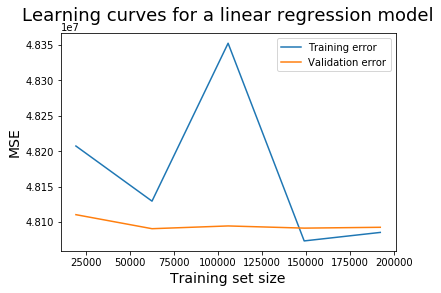

In [21]:
plt.plot(sizes, train_scores_mean, label = 'Training error')
plt.plot(sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

- Validation error seems to stay consistent for all the training sizes
- Training error increases as set size increases
    - We're not sure why this is; our training set size is incredibly large - over 200,000 observations in most cases. There should certainly be enough data to reliably do train/validation/test splits.

### Model Selection

#### Hyperparameter Tuning

As mentioned above, we now tune hyperparameters for the linear regression model.

This is another proof of concept: Since the general magnitude, mean, and variance of each variable vary quite significantly, the model should always be standardized. Additionally, in general, adding a constant (to adjust the y-intercept) helps the model. So we expect to see the best hyperparameters include a constant and normalize the data.

In [22]:
from sklearn.model_selection import KFold, GridSearchCV
kf = KFold(n_splits=5, shuffle=True)

reg = LinearRegression()
parameters = {"normalize":[True, False],
              "fit_intercept": [True, False]
             }

grid = GridSearchCV(estimator=reg, param_grid = parameters, cv = kf, 
                    scoring='r2')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [23]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,param_normalize,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.047273,0.002718,0.002992,3.234067e-07,True,True,"{'fit_intercept': True, 'normalize': True}",0.905538,0.906879,0.907453,0.905420,0.907141,0.906486,0.000843,1
1,0.043695,0.003187,0.003189,4.001569e-04,True,False,"{'fit_intercept': True, 'normalize': False}",0.905538,0.906879,0.907453,0.905420,0.907141,0.906486,0.000843,1
2,0.040487,0.002263,0.003394,4.917253e-04,False,True,"{'fit_intercept': False, 'normalize': True}",0.773330,0.771172,0.773638,0.774856,0.772976,0.773194,0.001193,3
3,0.038894,0.001648,0.002792,7.455133e-04,False,False,"{'fit_intercept': False, 'normalize': False}",0.773330,0.771172,0.773638,0.774856,0.772976,0.773194,0.001193,3


In [24]:
print("Best Score: ", grid.best_score_)
print("Best Params: ", grid.best_params_)

Best Score:  0.9064862817182655
Best Params:  {'fit_intercept': True, 'normalize': True}


In [25]:
reg_best = LinearRegression(fit_intercept= True, normalize= True).fit(X_train, y_train)
print("Training score: ", reg_best.score(X_train, y_train))
print("Testing score: ", reg_best.score(X_test, y_test))

Training score:  0.9065032069383963
Testing score:  0.9058242331166518


In [26]:
y_pred = reg_best.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: ", mean_absolute_error(y_test, y_pred))

RMSE:  6989.144681760124
MAE:  4553.541652821806


__We indeed find that the best estimator is the one which normalizes data and fits using an intercept.__

#### Algorithm Selection: varying the degree of polynomial regression
Now we move on from linear regression, and try nonlinear regression. We can once again use gridsearch to loop through hyperparameters: this time, we alter the degree of polynomial used in the regression.

It is worth noting that the SKlearn PolynomialFeatures function applies the polynomial features to existing data - in this case, our linear model. Since we found that our best linear model used and intercept and normalized data, we use the same options for our linear model in this section. Since we normalize using the LinearRegression setting, we do not include StandardScaler in the pipeline.

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [29]:
pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=True)),
    ('model', LinearRegression(fit_intercept= True, normalize= True)),])

poly_search = GridSearchCV(
    estimator=pipe,
    param_grid={'poly__degree': [1,2,3,4,5]},
    scoring='r2', verbose = 2,
    cv=kf
)
poly_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.1s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.1s
[CV] poly__degree=1 ..................................................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] ................................... poly__degree=1, total=   0.1s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.1s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.1s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.5s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.5s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.5s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.5s
[CV] poly__degree=2 ..................................................
[CV] 

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.8min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('model',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=True))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'poly__degree': [1, 2, 3, 4, 5]},
             p

In [30]:
pd.DataFrame(poly_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.081621,0.009038,0.004967,0.000627,1,{'poly__degree': 1},0.906473,0.905612,0.907121,0.907439,0.905820,0.906493,0.000710,5
1,0.458368,0.006615,0.028524,0.002046,2,{'poly__degree': 2},0.940360,0.939218,0.939609,0.940559,0.939882,0.939925,0.000489,4
2,2.220408,0.047967,0.106316,0.007479,3,{'poly__degree': 3},0.948001,0.946790,0.947437,0.948136,0.947594,0.947592,0.000475,3
3,8.736054,0.756643,0.296193,0.020481,4,{'poly__degree': 4},0.954087,0.952742,0.953455,0.954168,0.953705,0.953631,0.000514,2
4,32.729156,2.039578,0.756343,0.043463,5,{'poly__degree': 5},0.960230,0.958797,0.959854,0.960658,0.960118,0.959931,0.000624,1


In [31]:
print("Best Score: ", poly_search.best_score_)
print("Best Params: ", poly_search.best_params_)

Best Score:  0.9599314919804863
Best Params:  {'poly__degree': 5}


In [32]:
poly_best = poly_search.best_estimator_.fit(X_train,y_train)
print("Training score: ", poly_best.score(X_train, y_train))
print("Testing score: ", poly_best.score(X_test, y_test))

Training score:  0.9607421587676915
Testing score:  0.9597589139355108


In [33]:
y_pred = poly_best.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: ", mean_absolute_error(y_test, y_pred))

RMSE:  4568.6647950230235
MAE:  2761.605044685246


__Polynomial Degree 5 seems to have the best score, but is this the result of overfitting? To check, we generate a validation curve comparing degrees of fit over the entire dataset.__

In [34]:
from sklearn.model_selection import validation_curve
degrees = np.arange(1, 5)
model = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=True)),
    ('model', LinearRegression(fit_intercept= True, normalize= True)),])

In [35]:
train_scores, validation_scores = validation_curve(
                 model, X, y,
                 param_name='poly__degree',
                 param_range=degrees, verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.1s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.6s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   2.7s
[CV] poly__degree=4 ..................................................
[CV] ................................... poly__degree=4, total=  10.4s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.1s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.5s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   2.6s
[CV] p

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.3min finished


In [36]:
train_scores, validation_scores

(array([[0.90080151, 0.90124967, 0.90156539, 0.91799955, 0.89291134],
        [0.93564115, 0.93630923, 0.93632712, 0.94466554, 0.93905773],
        [0.94379882, 0.94425935, 0.94433277, 0.9529013 , 0.94735922],
        [0.95148169, 0.95202728, 0.95204402, 0.95911411, 0.95786459]]),
 array([[-1.43023956e-01, -1.25270974e-01, -1.17464736e-01,
          8.40537017e-01,  8.42682075e-02],
        [ 4.18911847e-01,  2.33251608e-01,  3.90531716e-01,
          9.06645190e-01,  3.04864819e-01],
        [ 5.13196347e-01,  2.78414354e-01,  4.89546694e-01,
          9.09493764e-01, -1.08531823e+21],
        [ 1.56964452e-01, -8.74540069e+00, -2.38287432e+00,
          8.97531868e-01, -1.12430578e+20]]))

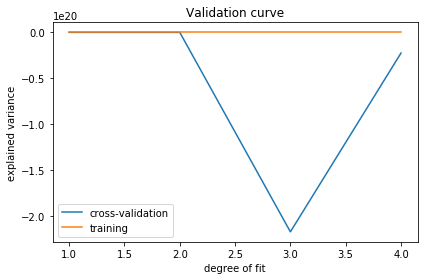

In [37]:
plt.figure(figsize=(6, 4))
plt.plot(degrees, validation_scores.mean(axis=1),
         label='cross-validation')
plt.plot(degrees, train_scores.mean(axis=1), label='training')

plt.legend(loc='best')
plt.xlabel('degree of fit')
plt.ylabel('explained variance')
plt.title('Validation curve')
plt.tight_layout()

- We see that training score is consistently high throughout the degrees of fit. We assume this is due to the high training size for our data
- Cross validation scores remain similarly high up until degree 2, and then decrease rapidly.
    - This suggests that using a polynomial regression of degree 5 may indeed cause overfitting to the training data. We should use degree one or two instead.

In [38]:
validation_scores.mean(axis=1)

array([ 1.07809112e-01,  4.50841036e-01, -2.17063646e+20, -2.24861155e+19])

In [39]:
training_scores.mean(axis=1)

array([-48207302.28404972, -48129510.61593349, -48352385.54530077,
       -48073364.19526364, -48085357.71999982])

In [40]:
np.argmax(validation_scores.mean(axis=1))

1

__We quickly test the performance of a degree 2 polynomial model:__

In [41]:
model = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree = 2, include_bias=False)),
    ('model', LinearRegression(fit_intercept= True, normalize= True)),])
model.fit(X_train, y_train)
print("Training score: ", model.score(X_train, y_train))
print("Testing score: ",model.score(X_test, y_test))

Training score:  0.9399624790123804
Testing score:  0.9395685092564328


In [42]:
y_pred = model.predict(X_test)

In [43]:
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: ", mean_absolute_error(y_test, y_pred))

RMSE:  5598.685884805855
MAE:  3508.95817026931


We find higher RMSE and MAE using this model than we do with the degree 5 model, however it is likely that this model is more interpretable, as it is a lower power. This is an interesting tradeoff (though for raw power, one might still consider using the degree 5 polynomial.

### Other regression variations
While polynomial regression seems to capture the true trend of prices a bit better, we still have extremely high error. This may be due to the overwhelming reflection of ticket classes (of which there are only 2) on price.

Recall the plot that displays variable importance, created in EDA. It found that class accounted for about 90% of the variation in price. This dwarfs other variables.

The validation curve we created above shows us that training error is lowest when the regression degree is 1 or 2. Our guess is that because ticket class has such a high contribution to ticket price that the regression uses class almost entirely. Class is nothing more than an indicator variable (taking only 0 or 1), and in this case, regression would simply be y=b if class 0, y = b + m if class 1, with a few extra subtle predictors using the remaining variables. This is little more than basic classification; in fact, price and duration, stops, etc. are linearly separable with respect to ticket class labels.

Clearly, this is not what we want, though. Being able to classify ticket class based on price and any other feature is cool but relatively useless - price is what is most cared about.

In [44]:
pd.DataFrame(y_test)
combined_test = X_test
combined_test.insert(0, 'price', y_test)

In [45]:
combined_test.head()

,price,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
73993,4262,2,5,1,1,0,3,1,9.50,27
290076,45185,1,1,1,1,2,2,0,12.83,45
225030,46720,1,5,1,1,3,2,0,17.08,2
254465,51817,5,0,2,1,4,4,0,13.75,27
870,12150,1,2,5,1,4,5,1,11.33,6


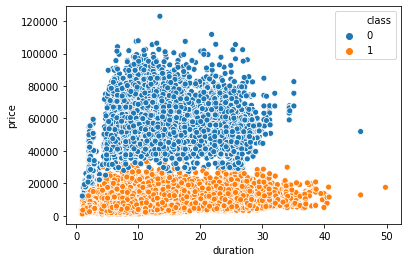

In [46]:
#linearly separable data!
sns.scatterplot(data=combined_test, x='duration', y='price', hue='class')

Text(0.5, 1.0, 'stops vs price')

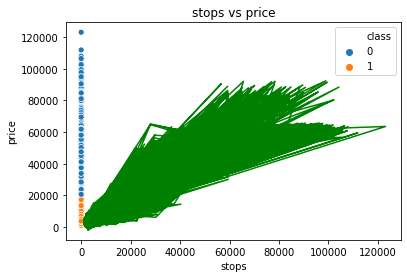

In [47]:
#as can be seen, multi-dimensional linear regression plots are not very interpretable
sns.scatterplot(data=combined_test, x='stops', y='price', hue='class')
plt.plot(y_test, y_pred, color='g')
plt.title('stops vs price')

__So, we have some other ideas to try using LR:__

1) It is clear that class is the largest feature in selection of price. Outside of class, how well can we predict price? We can start to test this by repeating linear regression using only tickets of a certain class.

2) Regression doesn't work well if variables are not correlated with whatever we're trying to predict (price, in this case). We  repeat linear regression with only key variables: ticket class, and whatever else is highly correlated with price.

### In-class Regression
Regression only using data from Economy class

As data is now only from a single class, price should vary far less (since it primarily varies between classes). Keeping class fixed, we see if we can achieve better price predictions.

We make use of the same tools employed in the last section: A gridsearch over degrees for a polynomial regression model applied to a linear regression model including an intercept and normalizing data. 

Results are once again evaluated using R^2, RMSE, and MAE measures.

In [48]:
#economy class: only class 1
#I am aware we have separate datasets for these, but I'd rather index the main dataset to keep notation and cleaning the same
economy_data = data.loc[data['class'] == 1]
economy_data.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,4,2,2,0,5,5,1,2.17,1,5953
1,4,2,1,0,4,5,1,2.33,1,5953
2,0,2,1,0,1,5,1,2.17,1,5956
3,5,2,4,0,0,5,1,2.25,1,5955
4,5,2,4,0,4,5,1,2.33,1,5955


In [49]:
X = economy_data.drop('price', axis=1)
y = economy_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
print(X_train.shape, y_train.shape)

(165332, 9) (165332,)


In [50]:
#start with linear regression, as before
kf = KFold(n_splits=5, shuffle=True)

reg = LinearRegression()
parameters = {"normalize":[True, False],
              "fit_intercept": [True, False]
             }

grid = GridSearchCV(estimator=reg, param_grid = parameters, cv = kf, 
                    scoring='r2')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [51]:
LR_economy_est = grid.best_estimator_.fit(X_train,y_train)
print("Best Score: ", grid.best_score_)
print("Best Params: ", grid.best_params_)

Best Score:  0.4479533471271512
Best Params:  {'fit_intercept': True, 'normalize': True}


We get the best score using an intercept and normalization, as before, but our best r^2 is far lower without class.

In [52]:
LR_economy_est

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [53]:
#now we apply the best estimator to a nonlinear regression scheme, as before
pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LR_economy_est)])

poly_search_econ = GridSearchCV(
    estimator=pipe,
    param_grid={'poly__degree': [1,2,3,4]},
    scoring='r2', verbose = 2,
    cv=kf
)
poly_search_econ.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.0s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.0s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.0s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.1s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.0s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.3s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.3s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.3s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.3s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.3s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   1.4s
[CV] 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   35.1s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=False,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('model',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=True))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'poly__degree': [1, 2, 3, 4]}, pre_dispatch='2*

In [54]:
#it seems degree 5 was too computationally intensive to fit, so it has been removed.
pd.DataFrame(poly_search_econ.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.043731,0.002938,0.003010,0.000015,1,{'poly__degree': 1},0.448757,0.450863,0.448294,0.446191,0.445712,0.447963,0.001863,4
1,0.249743,0.003344,0.019563,0.002856,2,{'poly__degree': 2},0.568063,0.571745,0.567213,0.571115,0.569887,0.569604,0.001734,3
2,1.255941,0.029660,0.061043,0.007502,3,{'poly__degree': 3},0.619756,0.624423,0.462239,0.627640,0.621686,0.591149,0.064510,2
3,5.212764,0.092731,0.190098,0.006096,4,{'poly__degree': 4},0.662991,0.670220,0.667970,0.670111,0.664721,0.667203,0.002900,1


In [55]:
print("Best Score: ", poly_search_econ.best_score_)
print("Best Params: ", poly_search_econ.best_params_)

Best Score:  0.667202842023524
Best Params:  {'poly__degree': 4}


In [56]:
poly_econ_best = poly_search_econ.best_estimator_.fit(X_train,y_train)
poly_econ_best

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=4, include_bias=False,
                                    interaction_only=False, order='C')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=True))],
         verbose=False)

In [57]:
y_pred = poly_econ_best.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: ", mean_absolute_error(y_test, y_pred))

RMSE:  2190.0679080319087
MAE:  1454.9506701504815


__This is quite interesting. Despite a lower R^2/accuracy score (0.67 here, compared to 0.94 in the between-classes model), this model has much lower RMSE and MAE than the between-class model (RMSE: 2160 here, compared to 5604 in the between-classes model).__

This implies that RMSE/MAE and R^2 metrics are not perfect mirrors of each other; a higher R^2 reflects a better measure of fit, but does not necessarily imply the model is "better" in the sense that it has less error.

We also acknowledge that prices vary less in within-class samples, and economy tickets are cheaper than business tickets, so RMSE ought to be lower than in the between-class-trained model. It is entirely possible that this RMSE is not indicative of great model performance in this case. Nonetheless, it is nice to see a comparatively low RMSE.

__We now recreate the validation curve (with respect to the polynomial degree) using this within_class dataset.__

In [58]:
#validation curve on entire dataset
degrees = np.arange(1, 5)
model = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression(fit_intercept= True, normalize= True)),])

train_scores, validation_scores = validation_curve(
                 model, X, y,
                 param_name='poly__degree',
                 param_range=degrees, verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.1s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.4s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   1.7s
[CV] poly__degree=4 ..................................................
[CV] ................................... poly__degree=4, total=   6.9s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.1s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.4s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   1.7s
[CV] p

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   51.0s finished


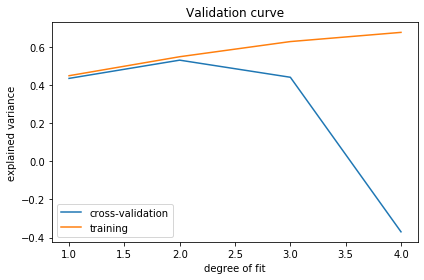

In [59]:
plt.figure(figsize=(6, 4))
plt.plot(degrees, validation_scores.mean(axis=1),
         label='cross-validation')
plt.plot(degrees, train_scores.mean(axis=1), label='training')

plt.legend(loc='best')
plt.xlabel('degree of fit')
plt.ylabel('explained variance')
plt.title('Validation curve')
plt.tight_layout()

Again, it seems that the best degree of fit for cross-validation (i.e. for testing) is 2, but the highest performance degree of fit (in regards to the training data) is degree 4. So, our highest accuracy comes from degree 4, but we should actually use a polynomial regression model with degree 2

### Regression with fewer variables
This is the same procedure as done above, except this time we want to limit the variables used to those which are the most salient. This means that we once again include ticket class, and 1-3 other variables.

To start, we should generate a correlation matrix of all the variables to each other

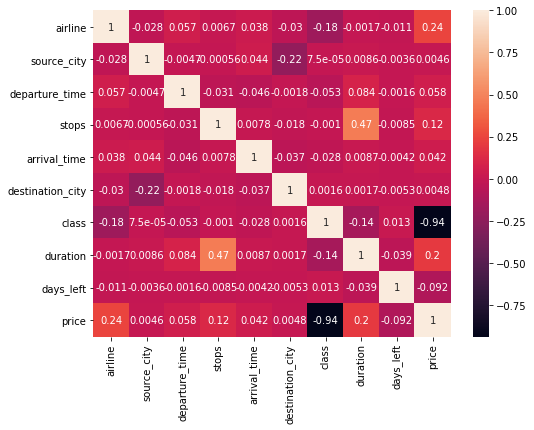

In [60]:
plt.figure(figsize = (8,6))
corrmat = data.corr()
sns.heatmap(corrmat, annot=True)
plt.show()

Aside from class, nothing has a correlation greater than .25. We'll include the duration, airline, and class labels, just to make it a bit more interesting. This means that we leave out the remaining 5 variables, each of which have a correlation of 5% or less.

It is worth noting that increasing the amount of variables used in regression should always increase training accuracy, but this is just overfitting if the extra included variables have no correlation with the predicted variable (price). Thus, we attempt to strike a balance between regression performance and clarity: the fewer variables we use, the more interpretable the model is, and the less prone it is to overfitting.

In [61]:
X = data[['class', 'airline', 'duration', 'stops']]
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
print(X_train.shape, y_train.shape)

(240122, 4) (240122,)


In [62]:
pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression(fit_intercept= True, normalize= True)),])

poly_search = GridSearchCV(
    estimator=pipe,
    param_grid={'poly__degree': [1,2,3,4,5]},
    scoring='r2', verbose = 2,
    cv=5
)
poly_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.0s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.0s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.0s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.0s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.0s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.1s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.1s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.1s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.1s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.1s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   0.2s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   0.3s
[CV] 

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    9.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=False,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('model',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=True))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'poly__degree': [1, 2, 3, 4, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,

In [63]:
poly_search.best_estimator_

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=5, include_bias=False,
                                    interaction_only=False, order='C')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=True))],
         verbose=False)

Again, we are suspicious of overfitting (degree 5 is likely only best for training). We generate another validation curve.

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve
degrees = np.arange(1, 5)
model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression(fit_intercept= True, normalize= False)),])
train_scores, validation_scores = validation_curve(
                 model, X, y,
                 param_name='poly__degree',
                 param_range=degrees, verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.1s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.1s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   0.3s
[CV] poly__degree=4 ..................................................
[CV] ................................... poly__degree=4, total=   0.7s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.1s
[CV] poly__degree=2 ..................................................
[CV] ................................... poly__degree=2, total=   0.1s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   0.3s
[CV] p

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.5s finished


In this case, it seems the best estimator actually is the 5th power!

In [65]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('model', LinearRegression(fit_intercept= True, normalize= False))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [66]:
pipe.score(X_test,y_test)

0.933190063252091

In [67]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse)

RMSE:  5867.231275476457


__We see that regression using only the 3-4 most highly correlated variables performs nearly as well as regression using each of the variables (5919 compared to 5604 in the all-variables case).__

__Another note:__ This validation curve looks different than the others. In this case, cross-validation performance seems to include as the polynomial degree increases. It never peaks in the range we have provided. So, __let's recreate this gridsearch with even higher powers and check the performance.__

In [68]:
#how artificially low can we pump rmse using powers above 5, since the cv curve didn't peak on the validation curve?
degrees = np.arange(1, 10, 2)
model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression(fit_intercept= True, normalize= False)),])
train_scores, validation_scores = validation_curve(
                 model, X, y,
                 param_name='poly__degree',
                 param_range=degrees, verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.1s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   0.3s
[CV] poly__degree=5 ..................................................
[CV] ................................... poly__degree=5, total=   1.2s
[CV] poly__degree=7 ..................................................
[CV] ................................... poly__degree=7, total=   4.3s
[CV] poly__degree=9 ..................................................
[CV] ................................... poly__degree=9, total=   9.9s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.1s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   0.3s
[CV] p

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.5min finished


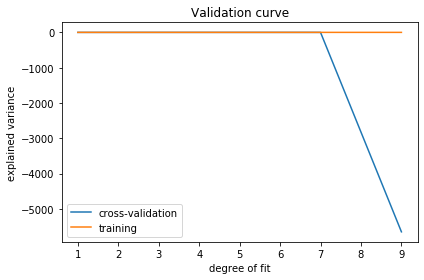

In [69]:
plt.figure(figsize=(6, 4))
plt.plot(degrees, validation_scores.mean(axis=1),
         label='cross-validation')
plt.plot(degrees, train_scores.mean(axis=1), label='training')

plt.legend(loc='best')
plt.xlabel('degree of fit')
plt.ylabel('explained variance')
plt.title('Validation curve')
plt.tight_layout()

In [70]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('model', LinearRegression(fit_intercept= True, normalize= False)),])

poly_search = GridSearchCV(
    estimator=pipe,
    param_grid={'poly__degree': [1,3,5,7,9]},
    scoring='r2', verbose = 2,
    cv=5
)
poly_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.0s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.0s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.0s
[CV] poly__degree=1 ..................................................
[CV] ................................... poly__degree=1, total=   0.0s
[CV] poly__degree=1 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................... poly__degree=1, total=   0.0s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   0.3s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   0.2s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   0.2s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   0.3s
[CV] poly__degree=3 ..................................................
[CV] ................................... poly__degree=3, total=   0.2s
[CV] poly__degree=5 ..................................................
[CV] ................................... poly__degree=5, total=   0.9s
[CV] poly__degree=5 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=False,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('model',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                           

In [71]:
high_poly_est = poly_search.best_estimator_

In [72]:
y_pred = high_poly_est.predict(X_test)

In [73]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse)

RMSE:  6712.387642301849


In [74]:
poly_search.score(X_test,y_test)

0.9125562641518167

Though the validation curve looks a bit different now, it seems clear that the validation performance peaks at about a 7th degree polynomial. This gives us higher R^2 but a somewhat similar RMSE. Additionally, we're not sure if it's overfitting. 7-degree polynomials are quite large and it's entirely possible this is just fitting the training as much as possible. Nonetheless, it is interesting to evaluate, and we are happy with the prospect that ideal regression performance can be approximated using less than half the original variables.

## Decision Tree Exploration

### Basic Tree

The next model we explored was the DecisionTree and its variations. Since the purpose of our project is to find out what factors impact flight price the most, the decision tree makes intuitive sense to be used in our analysis because it will tell us exactly what decisions lead to each price. 

We first established a "baseline" tree to see how our tree would look with the default hyperparameters. 

In [75]:
extra_trees_data = main_dataset

#Label Encoder encodes target labels with values between 0 and n_classes-1
#Labels are then normalized using the encoder
encoder = LabelEncoder()
extra_trees_data = extra_trees_data.drop(['flight'],axis=1)
extra_trees_data['airline'] = encoder.fit_transform(extra_trees_data['airline'])
extra_trees_data['source_city'] = encoder.fit_transform(extra_trees_data['source_city'])
extra_trees_data['departure_time'] = encoder.fit_transform(extra_trees_data['departure_time'])
extra_trees_data['stops'] = encoder.fit_transform(extra_trees_data['stops'])
extra_trees_data['arrival_time'] = encoder.fit_transform(extra_trees_data['arrival_time'])
extra_trees_data['destination_city'] = encoder.fit_transform(extra_trees_data['destination_city'])
extra_trees_data['class'] = encoder.fit_transform(extra_trees_data['class'])

X = extra_trees_data.drop('price', axis=1)
y = extra_trees_data['price']

feature_names = X.columns
labels = ["".join(item) for item in y.unique().astype(str)]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [76]:
dTree = DecisionTreeClassifier(max_depth = None, random_state = 42)
dTree.fit(X_train, y_train)
y_pred_dTree = dTree.predict(X_test)

In [77]:
print(dTree.get_depth())

40


Without changing any of the parameters, our baseline tree achieves a depth of 40. Unfortunately plotting this tree takes quite a while and so we were unable to get a plotted tree but we did get a text version of it and it saved under our repository: LINK

Unlike with the LinearRegression, with the DecisionTree we are actually able to see which factors were the most impactful in classifying price. The "class" feature was the first split followed by "destination city" and "source city" as the next two. Just from this baseline model we were able to gain insight on which factors are most influential - something which was not possible with the LinearRegression.

The training accuracy of this classifier is very high, but the testing accuracy is much lower which could indicate that the model does not generalize well. To combat this, our next step was to tune the hyperparameters while accounting for overfitting and we will do so with a GridSearch.

In [78]:
param = {
    "max_depth": [10,40,60],
    "min_samples_split":[20,40,60,80],
    "min_impurity_decrease": [0.0001, 0.001, 0.01]
}

grid = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid = param, cv = 10, verbose = 1, n_jobs = -1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


C:\Users\jasqi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.9min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [10, 40, 60],
                         'min

In [79]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'max_depth': 40, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=40, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
0.5068143509607574


After doing some research we decided to vary the tree parameters max_depth, min_samples_split, and min_impurity_decrease. We tried many ranges and combinations of these parameters and although this manual search was not exhaustive, we were able to narrow it down to one set of parameters that got the best accuracy within our search.

The best combination of the parameters was: 
{'max_depth': 40, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20}

With these tuned parameters, we were able to get the accuracies below. 

In [80]:
dTree_best = DecisionTreeClassifier(max_depth = 40, random_state = 42, min_impurity_decrease = 0.0001, min_samples_split = 20)
dTree_best.fit(X_train, y_train)
y_pred_dTree_best = dTree_best.predict(X_test)
print("Training Accuracy:",metrics.accuracy_score(y_train, dTree_best.predict(X_train)))
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred_dTree_best))

Training Accuracy: 0.5119184057855131
Testing Accuracy: 0.5047508628846333


### DecisionTreeRegressor

During our research with the DecisionTree, we came across the DecisionTreeRegressor, and we decided to explore it and compare it to the LinearRegression we had implemented earlier. Using the same hyperparameters as our "best" DecisionTree, we implemented the regressor. We got the following results:
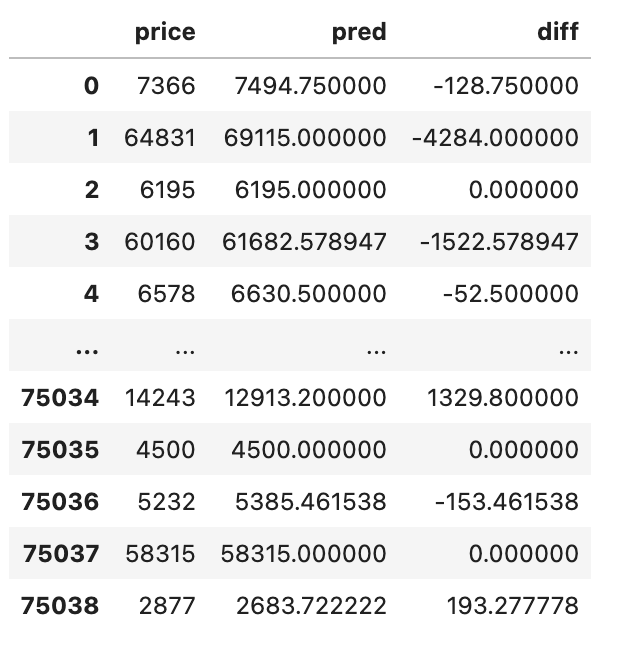

Clearly, there are still errors occuring, but to use a more concrete metric we calculated the RSME and MAE of this regressor.

RMSE:  3003.7394485653826
MAE:  1220.8235647611773

These values are much better than the values we got earlier for the linear regression, and in fact they are almost half of what we had gotten then.

### Bucketing DecisionTree

Moving back to our original DecisionTreeClassifier, we realized that the reason that our accuracies are so low may be due to the fact that there are so many different prices in our datatset and each prediction is being compared to one of these many prices. So, to fix this hurdle, we decided to "bucket" our prices or assign them to ranges so that our classifier had more leeway when being compared to the true values.

In [81]:
bucket_price = extra_trees_data.get("price")
len(bucket_price), len(bucket_price.unique())

(300153, 12157)

In [82]:
extra_trees_data["bucket_price"] = bucket_price
bins = np.arange(0, 100000, 1000)
extra_trees_data["bucket_price"] = pd.cut(extra_trees_data.bucket_price, bins).apply(lambda x: x.left)

In [83]:
extra_trees_data = extra_trees_data.dropna()

In [84]:
X = extra_trees_data.drop('price', axis=1)
X = X.drop('bucket_price', axis=1)
y = extra_trees_data['bucket_price']

feature_names = X.columns
labels = ["".join(item) for item in y.unique().astype(str)]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

We then ran a GridSearch with even more hyperparameters to try to get the highest accuracy we could. 

In [86]:
param = {
    "criterion": ['gini', 'entropy'],
    "max_depth": [None, 5, 10, 20, 30, 40, 50, 60],
    "max_features": [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    "min_samples_split":[5, 10, 20, 30, 40, 60, 80],
    "min_impurity_decrease": [0.00001, 0.0001, 0.001, 0.01]
}

grid = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid = param, cv = 10, verbose = 1, n_jobs = -1)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 3136 candidates, totalling 31360 fits


C:\Users\jasqi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  5.5min
[Parallel

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                      

The best parameter combination we got was:

    criterion: "entropy"
    max_depth: 30
    max_features: None
    min_impurity_decrease: 1e-05
    min_samples_split: 5

with a best score of 0.7667739447517467

Using these paramters we calculated the new accuracies with the bucketed data. 

In [87]:
dTree_best = grid.best_estimator_
dTree_best.fit(X_train, y_train)
y_pred_dTree_best = dTree_best.predict(X_test)
print("Training Accuracy:",metrics.accuracy_score(y_train, dTree_best.predict(X_train)))
print("Testing Accuracy:",metrics.accuracy_score(y_test, y_pred_dTree_best))

Training Accuracy: 0.8893397090062305
Testing Accuracy: 0.7759305674061433


These accuracies were significantly better than the ones without the bucketed data and the difference between test and train accuracies decreased, meaning that this model generalizes better than the previous one.

In [88]:
out = X_test
out["prediction"] = y_pred_dTree_best
out["diff"] = out["prediction"] - y_pred_dTree_best
out[out.get("diff") != 0]
out.get("diff").unique()

C:\Users\jasqi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jasqi\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([0], dtype=int64)

In [89]:
data = {"bucket": np.asarray(y_test), 
        "pred": y_pred_dTree_best}
out = pd.DataFrame(data)
out = out[out.get("bucket") != out.get("pred")]
out.get("bucket")
out["diff"] = out["bucket"] - out["pred"]
out

,bucket,pred,diff
2,5000,6000,-1000
9,57000,51000,6000
26,6000,7000,-1000
27,4000,7000,-3000
30,53000,45000,8000
...,...,...,...
74993,54000,70000,-16000
75000,5000,4000,1000
75003,16000,15000,1000
75005,58000,66000,-8000


In [90]:
# on average, each misclassification was off by just over 1 'bucket'
np.mean(out["diff"]) / 1000, np.median(out["diff"]) / 1000

(1.3607425477479622, 1.0)

On average each misclassification that our model had was off by just over 1 "bucket". For the purposes of our model, this error is still pretty useful because when predicting a price for a ticket a range gives the user a good estimate of their flight price. 

### RandomForest

Lastly, as a fun extension, we decided to attempt a RandomForest with the hyperparameters we found for our bucketed DecisionTree.

Training Accuracy: 0.907106860662513  
Testing Acccuracy: 0.786182807672355

You can see see that the testing accuracy did increase slightly when our best-parameter tree was combined into a forest. Given more time we could conduct grid search of the RandomForest's parameters to increase our accuracies even further.

# Discussion

### Interpreting the result

We found that the ticket class was the most important factor in determining the price, which makes sense intuitively with how flights work – business class seats are always significantly more expensive than economy class. However, running a LinearRegression model within each class of ticket did not produce high accuracy scores, indicating that either other features are not as important in determining ticket price, or they are not linear without taking ticket class into account. It is still worth noting, however, that the next most important factors in determining the price were the number of stops and the duration of the flight.  
After running the models, we found that the best one (based on test accuracy) is Random Forest, followed by Bucket Decision Tree, basic Decision Tree, and Linear Regression. It makes sense that a Random Forest would be better than the Decision Trees, since it is a collection of them, but it also suffers from being more computationally intensive and less interpretable. Considering it is only slightly better than Bucket Decision Trees, which are less computationally intensive, it may not be the most practical option. Using either a Random Forest or Bucket Decision Tree would predict the price of a flight with relatively good accuracy (~0.78) compared to basic Decision Trees or Linear Regression.

### Limitations

We were definitely limited by the processing power of our devices. For the grid searches we conducted, the more hyperparameters we varied, the longer it took to run, which restricted a lot of our progress. If we had more time to run or a device with faster processing, we would have been able to explore more hyperparameters and potentially reach a better accuracy for our models. Similarly, some of our members had issues running the RandomForest and for those who were able to run it, it took a very long time. Therefore one of our biggest challenges was finding ways to optimize our models and analysis while still being able to get a result from the run. 
We also faced the issue on how to compare our models because we comparing classifiers to regressors. There was not one metric across these models, therefore we had to rely on our intuition to decide which models worked better and this limitation was one of the main reasons we decided to implement a DecisionTreeRegressor because we were at least able to compare RSME with the LinearRegression. Thus, while we did draw conclusions from our analysis, it was not as cohesive as it could have been due to the difference in metrics.
Lastly, we had a lot of data which, besides being a challenge for running the code, may have also hindered the clarity of the results returned by the algorithms. If we had more time, it would be worth exploring if separating the data in different ways might give more meaningful and useful results.


### Ethics & Privacy

We have chosen this particular dataset as it minimizes the exposure of personally identifiable information, containing only details about the airline itself. Furthermore, this data is sourced from a publicly available website ‘Easemytrip’ and published on Kaggle, which provides users consent to explore, publish, and access the information.
Our model itself is used to predict the price alone and nothing that may cause ethical concerns once in production such as the specific flight route, passenger details, etc. Additionally, the data is based on previous flight routes alone.
We do acknowledge the possible bias in our dataset because all the flight routes are within a single country (India). This is a limitation in the generalizability of our model and will therefore limit its uses in production. We will ensure that this bias is highlighted to the users.


### Conclusion

Most importantly, ticket class is the main factor that determines the price of a ticket. However within ticket classes, predicting price very accurately is difficult. For future work, it may be worth separating the data by factors such as departure and arrival location, even if they may not be the most important factors in determining the price, since they are generally important to peoples’ travel plans. It is also worth trying out other algorithms and models for price prediction, since the ones in this project all gave accuracies of less than 0.8.

# **Footnotes**
<a name="grovesnote"></a>1.[^](#groves): Groves, William, and Maria Gini. "An agent for optimizing airline ticket purchasing." Proceedings of the 2013 international conference on Autonomous agents and multi-agent systems. 2013.<br> 
<a name="Wohlfarthnote"></a>2.[^](#Wohlfarth): Wohlfarth, Till, et al. "A data-mining approach to travel price forecasting." 2011 10th International Conference on Machine Learning and Applications and Workshops. Vol. 1. IEEE, 2011.<br>
<a name="Guonote"></a>3.[^](#Guo): Guo, Jau-Jia, and Peter B. Luh. "Improving market clearing price prediction by using a committee machine of neural networks." IEEE Transactions on Power Systems. 2004. <br>
<a name="Etzioninote"></a>4.[^](#Etzioni): Etzioni, Oren, et al. "To buy or not to buy: mining airfare data to minimize ticket purchase price." Proceedings of the ninth ACM SIGKDD international conference on Knowledge discovery and data mining. 2003.